python实现，遍历所有数据点，找出$n$个距离最近的点的分类情况，少数服从多数

In [1]:
import numpy as np
import random
import math
import time
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
# 实验参数：选择不同的数据集
dataset = datasets.load_iris()
#dataset = datasets.load_wine()
#dataset = datasets.load_breast_cancer()

In [3]:
# 实验参数：选择不同的数据规模
sample_rate = 0.5 # 采样率（可以选择小于1）
assert sample_rate>0 and sample_rate<=1
nSample = math.floor(dataset.data.shape[0]*sample_rate)
idx = random.sample(range(dataset.data.shape[0]), nSample)

X = dataset.data[idx][:]
y = dataset.target[idx][:]
y_stat = Counter(y)
print('======================= dataset information =======================')
print('Total sample number: %d, Feature dimension: %d, Category number: %d' % (X.shape[0], X.shape[1], len(y_stat)))
for category in y_stat:
    print('category %d has %d samples' % (category, y_stat[category]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Training sample number: %d, Test sample number: %d' % (X_train.shape[0], X_test.shape[0]))

======================= dataset information =======================
Total sample number: 75, Feature dimension: 4, Category number: 3
category 1 has 24 samples
category 2 has 27 samples
category 0 has 24 samples
Training sample number: 60, Test sample number: 15


In [4]:
from functools import wraps
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start=time.time()
        result=func(*args, **kwargs)
        end=time.time()
        print("It takes %.4fs for function[%s] to calculate precision over test set"%(end-start, func.__name__))
        return result
    return wrapper

In [5]:
#KNN类定义
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2): # 通过n_neighbors修改k值
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        # 取出n个点
        knn_list = []
        for i in range(self.n):
#             print(i)
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            knn_list.append((dist, self.y_train[i]))

        for i in range(self.n, len(self.X_train)):
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])

        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)
#         max_count = sorted(count_pairs, key=lambda x: x)[-1]
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        return max_count
    
    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [6]:
# 实验参数：选择不同的K值
K=3
assert K<=X_train.shape[0]
clf = KNN(X_train, y_train, K)
print('precision rate: {:.2%}'.format(clf.score(X_test, y_test)))

precision rate: 93.33%


In [7]:
# 实验参数：选择不同的测试样本
test_idx = 0
assert test_idx<X_test.shape[0]
test_point = X_test[0]
print('Test Point category: {}'.format(clf.predict(test_point)))

Test Point category: 2


## 作业部分

### 记录不同参数组合的准确度效果

In [8]:
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mlxtend.preprocessing import minmax_scaling
%matplotlib inline
mpl.style.use('seaborn')

In [9]:
dataset = datasets.load_iris()
sample_rates=[0.2, 0.4, 0.7, 1]
Ks=range(1, 21, 2)
freq=10
random.seed(time.time())

In [10]:
def adjust(dataset, sample_rates, Ks, freq=10):
    statistics={}
    
    data = minmax_scaling(dataset.data, columns=list(range(dataset.data.shape[1])))
    for rate in sample_rates:
        for K in Ks:
            for i in range(freq):
                nSample=math.floor(data.shape[0]*rate)
                idx=random.sample(range(data.shape[0]), nSample)

                X=data[idx, :]
                y=dataset.target[idx]

                y_stat = Counter(y)
    #             print('==========================dataset information=========================')
    #             print('Total sample number: %d, Feature dimension: %d, Category number: %d'%(X.shape[0], X.shape[1], len(y_stat)))

    #             for category in y_stat:
    #                 print('Category %d has %d samples'%(category, y_stat[category]))

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #             print('Training sample number: %d, Test sample number: %d'%(X_train.shape[0], X_test.shape[0]))

                clf=KNN(X_train, y_train, K)

                statistics[rate][K]=statistics.setdefault(rate, {}).setdefault(K, 0)+clf.score(X_test, y_test)

    #         print('\n\n')
            statistics[rate][K]/=freq
        
    return pd.DataFrame(statistics)*100

In [11]:
iris = adjust(dataset, sample_rates, range(1, 21, 2))

In [12]:
iris

,0.2,0.4,0.7,1.0
1,93.333333,94.444444,94.6875,95.555556
3,92.222222,95.000000,96.2500,96.666667
5,87.777778,93.888889,97.1875,95.111111
7,94.444444,91.666667,97.1875,95.333333
9,75.555556,98.333333,94.0625,96.222222
11,72.222222,92.777778,94.3750,97.333333
13,53.333333,92.222222,94.3750,95.777778
15,62.222222,87.777778,96.2500,96.000000
17,58.888889,85.555556,94.3750,96.666667
19,37.777778,92.222222,94.3750,94.444444


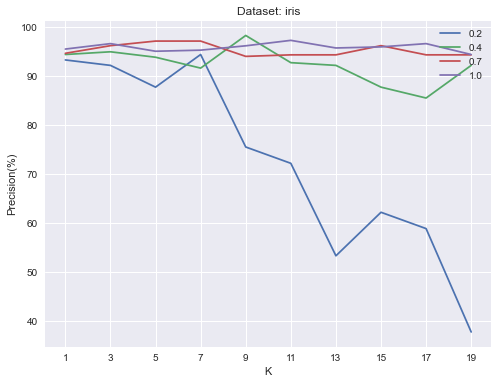

In [13]:
axes_iris=iris.plot.line(
    figsize=(8, 6),
    rot=0,
#     width=0.8,
    xlabel='K',
    ylabel='Precision(%)',
    title='Dataset: iris'
)
axes_iris.legend(loc=1)
axes_iris.set_xticks(Ks)
plt.gcf().savefig('iris_statistics.png')

In [14]:
breast_cancer = adjust(datasets.load_wine(), sample_rates, range(1, 21, 2))

In [15]:
breast_cancer

,0.2,0.4,0.7,1.0
1,94.545455,92.727273,97.105263,95.185185
3,95.454545,92.727273,96.052632,95.185185
5,90.909091,96.818182,96.315789,95.185185
7,94.545455,93.636364,93.947368,95.370370
9,80.000000,97.272727,97.631579,96.851852
11,80.909091,95.909091,96.315789,97.407407
13,75.454545,94.545455,95.263158,95.555556
15,54.545455,94.545455,96.052632,96.481481
17,65.454545,93.636364,97.105263,97.592593
19,48.181818,93.636364,95.789474,96.296296


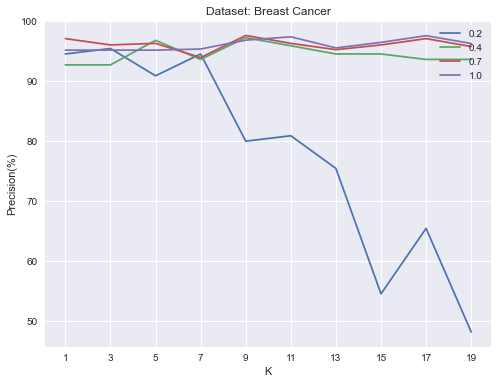

In [16]:
axes_breast=breast_cancer.plot.line(
    figsize=(8, 6),
    rot=0,
#     width=0.8,
    xlabel='K',
    ylabel='Precision(%)',
    xticks=Ks,
    title='Dataset: Breast Cancer'
)
axes_breast.legend(loc=1)
plt.gcf().savefig('breast_statistics.png')

In [17]:
wine=adjust(datasets.load_wine(), sample_rates, Ks)

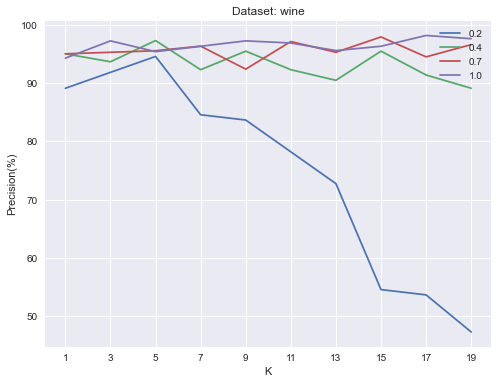

In [18]:
axes_wine=wine.plot.line(
    figsize=(8, 6),
    rot=0,
#     width=0.8,
    xlabel='K',
    ylabel='Precision(%)',
    xticks=Ks,
    title='Dataset: wine'
)
axes_wine.legend(loc=1)
plt.gcf().savefig('wine_statistics.png')

### 分析产生相关结果的原因

#### 提供自适应的超参数选择策略

In [19]:
def kfold(X_train, y_train, Ks, kfold=5, val_error=True):
    ret = {}
    X_train=minmax_scaling(X_train, columns=list(range(X_train.shape[1])))
    data=np.c_[X_train, y_train]
    random.shuffle(data)
    fold_size=len(data)//kfold

    for K in Ks:
        for i in range(kfold):
            idx_val=list(range(i*fold_size, (i+1)*fold_size-1))
            idx_train = ~np.isin(list(range(len(data))), idx_val)
            X_train=data[idx_train, :-1]
            y_train=data[idx_train, -1]
            X_val  =data[idx_val, :-1]
            y_val  =data[idx_val, -1]
            
#             print(idx_val)
#             print(K, X_train.shape[1], y_train)
            knn = KNN(X_train, y_train, K, 2)
            ret[K]=ret.setdefault(K, 0)+knn.score(X_val, y_val)
        
        ret[K]/=kfold
        ret[K]=(1-ret[K])*100
    
    min_error_k = sorted(ret.items(), key=lambda pair:pair[1])[0][0]
    min_error_rate = ret[min_error_k]
    for k, v in ret.items():
        if v==min_error_rate and k>min_error_k:
            min_error_k=k
    
    return min_error_k, ret

In [20]:
breast_cancer = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test=train_test_split(breast_cancer.data, breast_cancer.target, test_size=0.2, random_state=True)

In [21]:
min_error_k, error_val = kfold(X_train, y_train, range(2, 21))

In [22]:
min_error_k

2

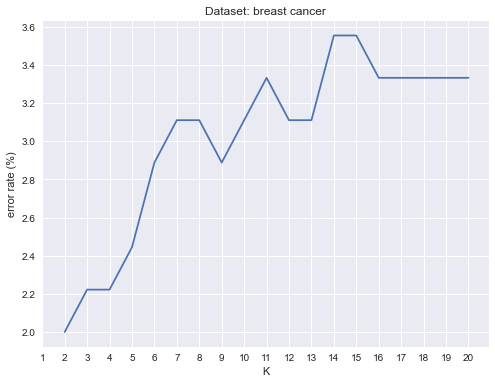

In [23]:
pd.DataFrame(error_val.values(), index=range(2, 21)).plot.line(
    xticks=range(1, 21), 
    legend=None,
    xlabel='K',
    ylabel='error rate (%)',
    title='Dataset: breast cancer',
    figsize=(8, 6)
)
plt.gcf().savefig('breast cancer k.png')

In [24]:
iris=datasets.load_iris()
X_train, _, y_train, _=train_test_split(iris.data, iris.target, test_size=0.2, random_state=True)
min_error_k, error_val=kfold(X_train, y_train, range(2, 21))

In [25]:
min_error_k

9

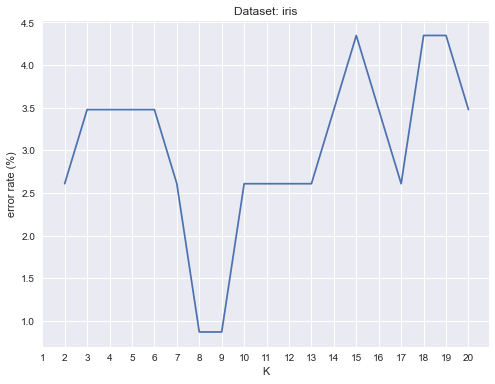

In [26]:
pd.DataFrame(error_val.values(), index=range(2, 21)).plot.line(
    xticks=range(1, 21),
    legend=None,
    xlabel='K',
    ylabel='error rate (%)',
    title='Dataset: iris', 
    figsize=(8, 6)
)
plt.gcf().savefig('iris k value.png')

#### 使用kd-tree算法提高算法效率

In [27]:
import operator
import datetime
import numpy as np
import pandas as pd

In [28]:
#KNN类定义
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2): # 通过n_neighbors修改k值
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        # 取出n个点
        knn_list = []
        for i in range(self.n):
#             print(i)
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            knn_list.append((dist, self.y_train[i]))

        for i in range(self.n, len(self.X_train)):
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])

        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)
#         max_count = sorted(count_pairs, key=lambda x: x)[-1]
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        return max_count
    
    @timeit
    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [29]:
class kdtree(object):
    
    # 创建 kdtree
    # point_list 是一个 list 的 pair，pair[0] 是一 tuple 的特征，pair[1] 是类别
    def __init__(self, point_list, depth=0, root=None):
        
        if len(point_list)>0:
            
            # 轮换按照树深度选择坐标轴
            k = len(point_list[0][0])
            axis = depth % k
            
            # 选中位线，切
            point_list.sort(key=lambda x:x[0][axis])
            median = len(point_list) // 2
            
            self.axis = axis
            self.root = root
            self.size = len(point_list)
            
            # 造节点
            self.node = point_list[median]
            # 递归造左枝和右枝
            if len(point_list[:median])>0:
                self.left = kdtree(point_list[:median], depth+1, self)
            else:
                self.left = None
            if len(point_list[median+1:])>0:
                self.right = kdtree(point_list[median+1:], depth+1, self)
            else:
                self.right = None
            # 记录是按哪个方向切的还有树根

        else:
            return None
    
    # 在树上加一点
    def insert(self, point):
        self.size += 1
        
        # 分析是左还是右，递归加在叶子上
        if point[0][self.axis]<self.node[0][self.axis]:
            if self.left!=None:
                self.left.insert(point)
            else:
                self.left = kdtree([point], self.axis+1, self)
        else:
            if self.right!=None:
                self.right.insert(point)
            else:
                self.right = kdtree([point], self.axis+1, self)
            
            
    # 输入一点
    # 按切分寻找叶子
    def find_leaf(self, point):
        if self.left==None and self.right==None:
            return self
        elif self.left==None:
            return self.right.find_leaf(point)
        elif self.right==None:
            return self.left.find_leaf(point)
        elif point[0][self.axis]<self.node[0][self.axis]:
            return self.left.find_leaf(point)
        else:
            return self.right.find_leaf(point)
        

    # 查找最近的 k 个点，复杂度 O(DlogN)，D是维度，N是树的大小
    # 输入一点、一距离函数、一k。距离函数默认是 L_2
    def knearest(self, point, k=1, dist=lambda x,y: sum(map(lambda u,v:(u-v)**2,x,y))):
        # 往下戳到最底叶
        leaf = self.find_leaf(point)
        # 从叶子往上爬
        return leaf.k_down_up(point, k, dist, result=[], stop=self, visited=None)


    # 从下往上爬函数，stop是到哪里去，visited是从哪里来
    def k_down_up(self, point,k, dist, result=[],stop=None, visited=None):

        # 选最长距离
        if result==[]:
            max_dist = 0
        else:
            max_dist = max([x[1] for x in result])

        other_result=[]
        
#         print(self.node[0][self.axis])
#         print(point[0][self.axis])
#         print(max_dist)
        
        # 如果离分界线的距离小于现有最大距离，或者数据点不够，就从另一边的树根开始刨
        if (self.left==visited and self.node[0][self.axis]-point[0][self.axis]<max_dist and self.right!=None)\
            or (len(result)<k and self.left==visited and self.right!=None):
            other_result=self.right.knearest(point,k, dist)
    
        if (self.right==visited and point[0][self.axis]-self.node[0][self.axis]<max_dist and self.left!=None)\
            or (len(result)<k and self.right==visited and self.left!=None):
            other_result=self.left.knearest(point, k, dist)

        # 刨出来的点放一起，选前 k 个
        result.append((self.node, dist(point[0], self.node[0])))
        result = sorted(result+other_result, key=lambda pair: pair[1])[:k]

        # 到停点就返回结果
        if self==stop:
            return result
        # 没有就带着现有结果接着往上爬
        else:
            return self.root.k_down_up(point,k,  dist, result, stop, self)

    # 输入 特征、类别、k、距离函数
    # 返回这个点属于该类别的概率
    def kNN_prob(self, point, label, k, dist=lambda x,y: sum(map(lambda u,v:(u-v)**2,x,y))):
        nearests = self.knearest(point,  k, dist)
        return float(len([pair for pair in nearests if pair[0][1]==label]))/float(len(nearests))


    # 输入 特征、k、距离函数
    # 返回该点概率最大的类别以及相对应的概率
    def kNN(self, point, k, dist=lambda x,y: sum(map(lambda u,v:(u-v)**2,x,y))):
        nearests = self.knearest(point, k , dist)

        statistics = {}
        for data in nearests:
            label = data[0][1]
            if label not in statistics: 
                statistics[label] = 1
            else:
                statistics[label] += 1
        
#         print(statistics)
        max_label = max(statistics.items(), key=operator.itemgetter(1))[0]
        return max_label, float(statistics[max_label])/float(len(nearests))
    
    @timeit
    def score(self, test_data, k):
        right_count=0
        for point in test_data:
            label, _=self.kNN(point, k)
            if(label==point[1]):
                right_count+=1
        return right_count/len(test_data)

##### iris数据集

In [66]:
breast_cancer = datasets.load_iris()
data = np.c_[breast_cancer.data, breast_cancer.target]
data = minmax_scaling(data, columns=range(data.shape[1]-1))
data = np.c_[data, breast_cancer.target]

In [67]:
data

array([[0.22222222, 0.625     , 0.06779661, 0.04166667, 0.        ],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667, 0.        ],
       [0.11111111, 0.5       , 0.05084746, 0.04166667, 0.        ],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667, 0.        ],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667, 0.        ],
       [0.30555556, 0.79166667, 0.11864407, 0.125     , 0.        ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333, 0.        ],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667, 0.        ],
       [0.02777778, 0.375     , 0.06779661, 0.04166667, 0.        ],
       [0.16666667, 0.45833333, 0.08474576, 0.        , 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667, 0.        ],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667, 0.        ],
       [0.13888889, 0.41666667, 0.06779661, 0.        , 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        , 0.        ],
       [0.41666667, 0.83333333, 0.

In [68]:
random.shuffle(data)
train_rate=0.7
nSample=math.floor(len(data)*train_rate)
idx_train = random.sample(range(len(data)), nSample)
idx_test  = ~np.isin(range(len(data)), idx_train)

In [69]:
train_data = data[idx_train, :]
test_data  = data[idx_test, :]

In [70]:
K=5

##### i. brute force

In [71]:
brute_X_train=train_data[:, :-1]
brute_y_train=train_data[:, -1]
brute_X_test=test_data[:, :-1]
brute_y_test=test_data[:, -1]

In [72]:
knn = KNN(brute_X_train, brute_y_train, K)
knn.score(brute_X_test, brute_y_test)

It takes 0.0369s for function[score] to calculate precision over test set


0.9555555555555556

##### ii. kd-tree

In [73]:
kd_train_data=list(map(lambda x:[tuple(x[:-1]), x[-1]], train_data))
kd_test_data =list(map(lambda x:[tuple(x[:-1]), x[-1]], test_data))

In [74]:
kd_tree=kdtree(kd_train_data)
kd_tree.score(kd_test_data, K)

It takes 0.0080s for function[score] to calculate precision over test set


0.9555555555555556

##### breast_cancer 数据集

In [75]:
K=18

In [76]:
breast_cancer = datasets.load_breast_cancer()
data = np.c_[breast_cancer.data, breast_cancer.target]
data = minmax_scaling(data, columns=range(data.shape[1]-1))
data = np.c_[data, breast_cancer.target]

In [77]:
data

array([[0.52103744, 0.0226581 , 0.54598853, ..., 0.59846245, 0.41886396,
        0.        ],
       [0.64314449, 0.27257355, 0.61578329, ..., 0.23358959, 0.22287813,
        0.        ],
       [0.60149557, 0.3902604 , 0.59574321, ..., 0.40370589, 0.21343303,
        0.        ],
       ...,
       [0.45525108, 0.62123774, 0.44578813, ..., 0.12872068, 0.1519087 ,
        0.        ],
       [0.64456434, 0.66351031, 0.66553797, ..., 0.49714173, 0.45231536,
        0.        ],
       [0.03686876, 0.50152181, 0.02853984, ..., 0.25744136, 0.10068215,
        1.        ]])

In [78]:
random.shuffle(data)
train_rate=0.7
nSample=math.floor(len(data)*train_rate)
idx_train = random.sample(range(len(data)), nSample)
idx_test  = ~np.isin(range(len(data)), idx_train)

In [79]:
train_data = data[idx_train, :]
test_data  = data[idx_test, :]

##### i. brute force

In [80]:
brute_X_train=train_data[:, :-1]
brute_y_train=train_data[:, -1]
brute_X_test=test_data[:, :-1]
brute_y_test=test_data[:, -1]

In [81]:
knn = KNN(brute_X_train, brute_y_train, K)
knn.score(brute_X_test, brute_y_test)

It takes 0.5909s for function[score] to calculate precision over test set


0.9415204678362573

##### ii. kd-tree

In [82]:
kd_train_data=list(map(lambda x:[tuple(x[:-1]), x[-1]], train_data))
kd_test_data =list(map(lambda x:[tuple(x[:-1]), x[-1]], test_data))

In [83]:
kd_tree=kdtree(kd_train_data)
kd_tree.score(kd_test_data, K)

It takes 1.3535s for function[score] to calculate precision over test set


0.9415204678362573